# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [1]:
# Install requirements
!python -m pip install -r requirements.txt

  Using cached bokeh-2.1.1.tar.gz (19.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [35 lines of output]
  C:\Users\marce\anaconda3\envs\AIML\lib\site-packages\setuptools\dist.py:805: SetuptoolsDeprecationWarning: Deprecated API usage.
  !!
  
          ********************************************************************************
          As setuptools moves its configuration towards `pyproject.toml`,
          `setuptools.config.parse_configuration` became deprecated.
  
          For the time being, you can use the `setuptools.config.setupcfg` module
          to access a backward compatible API, but this module is provisional
          and might be removed in the future.
  
          To read project metadata, consider using
          ``build.util.project_wheel_metadata`` (https://pypi.org/project/build/).
          For simple scenarios, you can also try parsing the file directly
          with the help of ``configparser``.
          ****************

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [17]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values
])

# Create training set and define training dataloader
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

### Preprocessing Justification:

The chosen preprocessing steps include converting images to tensors and normalizing pixel values. Converting to tensors is essential for feeding the images into a neural network as tensors are the primary data structure used in PyTorch for training models. 

Normalization is performed to bring the pixel values to a similar scale, which helps in stabilizing and speeding up the training process. By normalizing the pixel values, we ensure that the neural network learns more effectively, as large differences in pixel values across images could lead to slower convergence during training. Normalization also helps in avoiding issues like vanishing or exploding gradients, which can occur when working with raw pixel values that are not scaled appropriately.

Overall, these preprocessing steps are necessary to prepare the data for training a neural network effectively.


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [18]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Training dataset size: 60000
Test dataset size: 10000
Shape of training images: torch.Size([64, 1, 28, 28])
Shape of training labels: torch.Size([64])
Shape of test images: torch.Size([64, 1, 28, 28])
Shape of test labels: torch.Size([64])
Sample of images from the training dataset


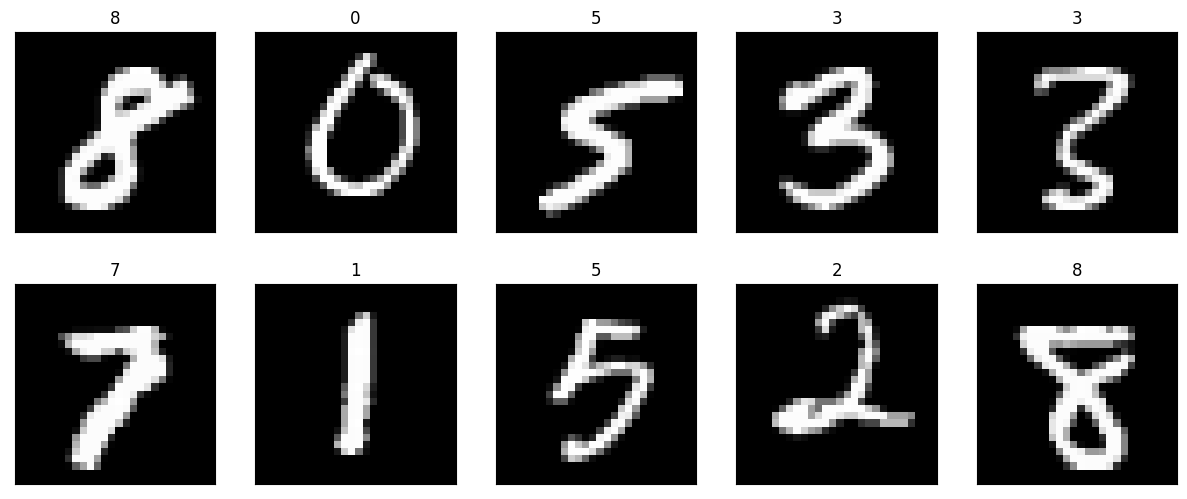

Sample of images from the test dataset


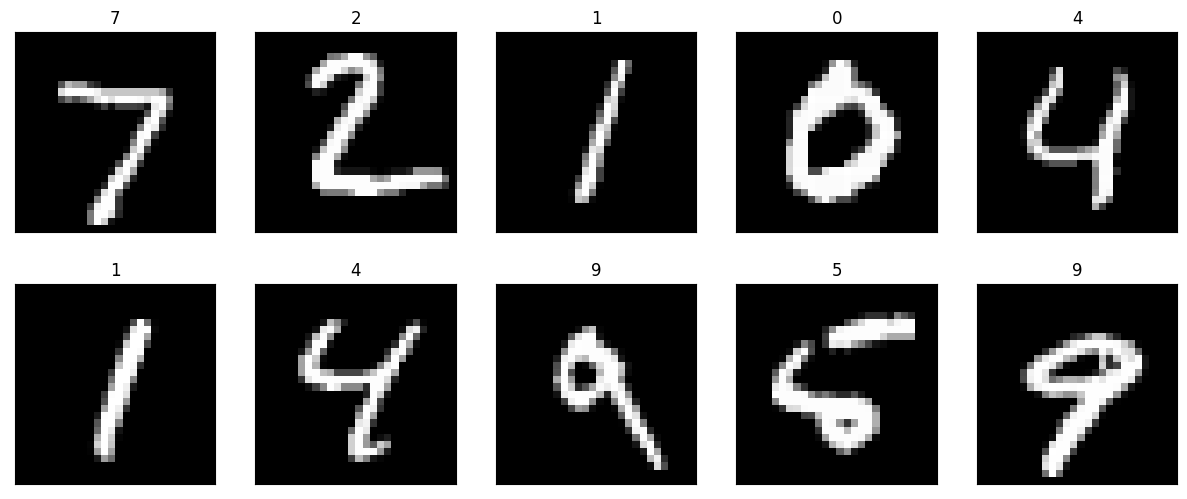

In [19]:
# Explore data
print("Training dataset size:", len(train_set))
print("Test dataset size:", len(test_set))

# Print the shape of images and labels
print("Shape of training images:", next(iter(train_loader))[0].shape)
print("Shape of training labels:", next(iter(train_loader))[1].shape)
print("Shape of test images:", next(iter(test_loader))[0].shape)
print("Shape of test labels:", next(iter(test_loader))[1].shape)

def show_samples(dataset_loader):
    dataiter = iter(dataset_loader)
    images, labels = next(dataiter)
    images = images.numpy()
    
    fig = plt.figure(figsize=(15, 6))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title(str(labels[idx].item()))


# Show sample of images from the training dataset
print("Sample of images from the training dataset")
show_samples(train_loader)
plt.show()

# Show sample of images from the test dataset
print("Sample of images from the test dataset")
show_samples(test_loader)
plt.show()



## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Instantiate the model
model = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [21]:
# Specify loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

# Initialize an empty list to store the training loss values
loss_values = []

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 250 == 249:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 250:.3f}')
            loss_values.append(running_loss / 250)  # Append the average loss for the batch
            running_loss = 0.0
print('Finished Training')

Device: cpu
[1, 250] loss: 0.669
[1, 500] loss: 0.352
[1, 750] loss: 0.280
[2, 250] loss: 0.226
[2, 500] loss: 0.191
[2, 750] loss: 0.178
[3, 250] loss: 0.148
[3, 500] loss: 0.135
[3, 750] loss: 0.134
[4, 250] loss: 0.110
[4, 500] loss: 0.120
[4, 750] loss: 0.111
[5, 250] loss: 0.095
[5, 500] loss: 0.093
[5, 750] loss: 0.091
Finished Training


Plot the training loss (and validation loss/accuracy, if recorded).

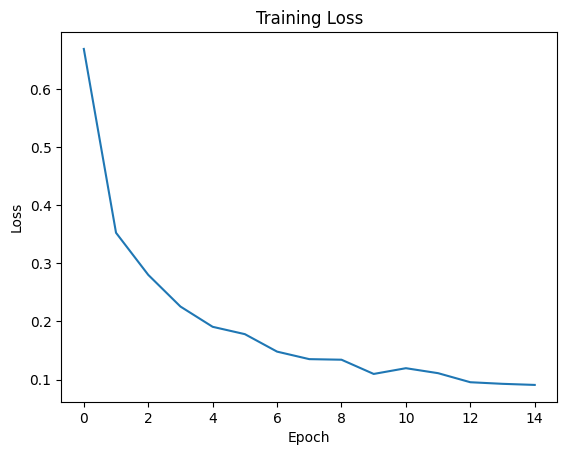

In [23]:
# Plot the training loss
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [25]:
# Tweak hyperparameters
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate
epochs = 10  # Increase number of epochs
batch_size = 128  # Change batch size

# Retrain the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model.to(device)

# Initialise an empty list to store the training loss values
loss_values = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 250 == 249:
            print(f'[{epoch + 1}, {i +1}] loss: {running_loss / 250:.3f}')
            loss_values.append(running_loss / 250)  # Append the average loss for the batch
            running_loss = 0.0
print('Finish Training')


Device: cpu
[1, 250] loss: 0.085
[1, 500] loss: 0.083
[1, 750] loss: 0.081
[2, 250] loss: 0.071
[2, 500] loss: 0.077
[2, 750] loss: 0.070
[3, 250] loss: 0.060
[3, 500] loss: 0.058
[3, 750] loss: 0.070
[4, 250] loss: 0.055
[4, 500] loss: 0.057
[4, 750] loss: 0.060
[5, 250] loss: 0.050
[5, 500] loss: 0.054
[5, 750] loss: 0.052
[6, 250] loss: 0.049
[6, 500] loss: 0.048
[6, 750] loss: 0.045
[7, 250] loss: 0.039
[7, 500] loss: 0.045
[7, 750] loss: 0.051
[8, 250] loss: 0.033
[8, 500] loss: 0.035
[8, 750] loss: 0.045
[9, 250] loss: 0.029
[9, 500] loss: 0.034
[9, 750] loss: 0.037
[10, 250] loss: 0.041
[10, 500] loss: 0.038
[10, 750] loss: 0.041
Finish Training


## Saving your model
Using `torch.save`, save your model for future loading.

In [26]:
# Save the model
torch.save(model.state_dict(), 'mnist_model.pth')